# SciKit-LearnML Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

import new_classifier_utilities as cu

In [28]:
import importlib
importlib.reload(cu)

<module 'new_classifier_utilities' from '/host/Code/florence_mapping/new_classifier_utilities.py'>

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]

ndvi_image_paths = [
    '/deep_data/ndvi_yearly/aligned-stackedImage_027012_20170907.tif'
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))
    
ndvi_datasets = []
for fp in ndvi_image_paths:
    ndvi_datasets.append(rasterio.open(fp))



### Class Dictionary and Confusion Matrix Function

In [3]:
class_names = dict((
(0, "Water"),
(1, "Snow/Ice"),
(2, "Open Space Developed"),
(3, "Low Intensity Developed"),
(4, "Medium Intensity Developed"),
(5, "High Intensity Developed"),
(6, "Barren Land"),
(7, "Deciduous Forest"),
(8, "Evergreen Forest"),
(9, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(10, "Scrub/Shrub"),
(11, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(12, "Pasture/Hay"),
(13, "Cultivated Land"),
(14, "Woody Wetland"),
(15, "Emergent Herbaceous Wetlands"),
))

class_to_index = dict((
    (11, 0),
    (12, 1),
    (21, 2),
    (22, 3),
    (23, 4),
    (24, 5),
    (31, 6),
    (41, 7),
    (42, 8),
    (43, 9),
    (52, 10),
    (71, 11),
    (81, 12),
    (82, 13),
    (90, 14),
    (95, 15),
    ))

## Scikit-learn ML Approaches

### Prep Data for training and validation

In [6]:
# get pixel locations
train_pixels = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[:1], train_count=10000, 
                                            label_dataset=label_dataset, merge=False)


train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

100%|██████████| 1/1 [00:44<00:00, 44.79s/it]


In [8]:
# get training data from those pixel locations
batch_size = len(train_px)
sk_im_batch, sk_label_batch = cu.pixel_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                              ndvi_datasets, label_dataset, train_px, batch_size, merge=False)
print(sk_im_batch.shape, sk_label_batch.shape)

(7500, 22) (7500, 16)


In [9]:
batch_size = len(val_px)
sk_im_batch_val, sk_label_batch_val = cu.pixel_generator(landsat_datasets, sentinel_datasets, 
                                            dem_datasets, ndvi_datasets, label_dataset, val_px, batch_size, merge=False)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(1875, 22) (1875, 16)


In [10]:
unique, counts = np.unique(np.argmax(sk_label_batch, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 600,
 2: 525,
 3: 490,
 4: 491,
 5: 521,
 6: 191,
 7: 284,
 8: 563,
 9: 427,
 10: 620,
 11: 489,
 12: 438,
 13: 586,
 14: 612,
 15: 663}

### K Nearest Neighbors

Create an instance of Neighbours Classifier and fit the data.

In [11]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='distance')

Now assess the model

In [12]:
label_index = np.argmax(sk_label_batch_val, axis=1)

clf.score(sk_im_batch_val, label_index)

0.456

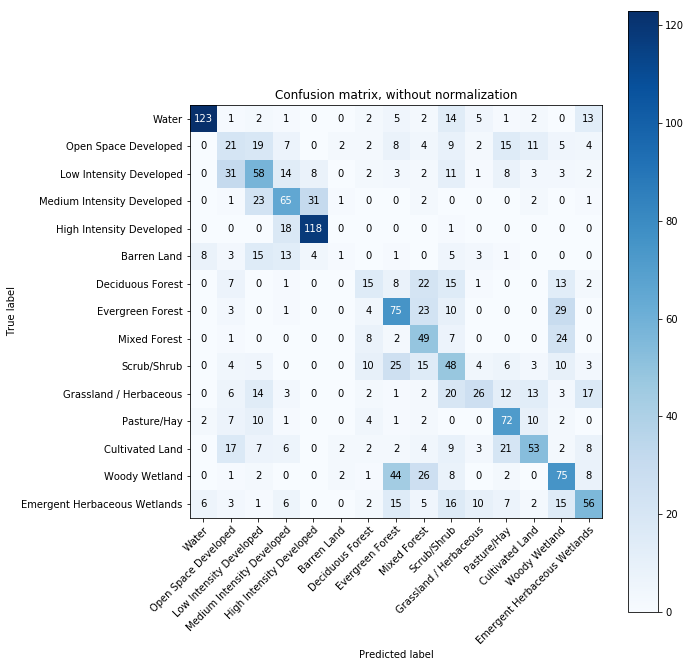

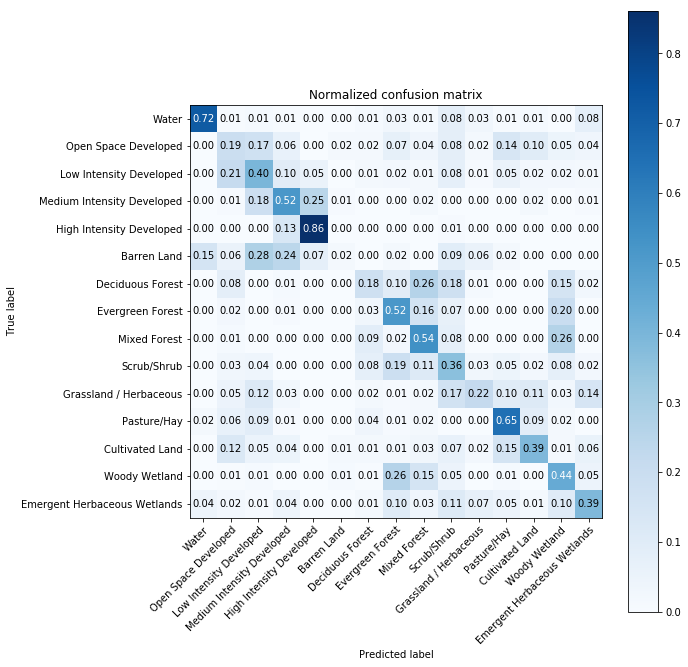

In [14]:
pred_index = clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [11]:
def merge_classes_extra(y):
    # medium intensity and high intensity
    y[y == 3] = 2
    # open space developed, cultivated land, and pasture hay
    y[y == 5] = 6
    y[y == 7] = 6
    # decidious and mixed
    y[y == 9] = 11
    # evergreen and scrub shrub
    y[y == 12] = 10
    # pal wetland and pal scrub shrub
    y[y == 14] = 15
    # est forest and est scrub shrub
    y[y == 17] = 16
    
    ###
    # merge developed
    y[y == 2] = 4
    # merge evergreen and mixed forest
    y[y == 10] = 11
    
    return(y)

(array([775.,   0., 701.,   0., 627., 649., 653.,   0., 212., 352., 670.,
          0., 566., 752., 596.,   0., 559., 715., 748., 800.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <a list of 20 Patch objects>)

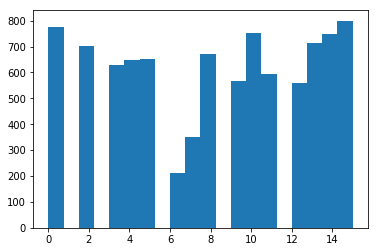

In [22]:
plt.hist(np.argmax(sk_label_batch_val, axis=1), bins=20)

(array([671.,   0., 284.,   0., 692., 645., 751.,   0.,  75., 294., 862.,
          0., 681., 734., 567.,   0., 727., 725., 812., 855.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <a list of 20 Patch objects>)

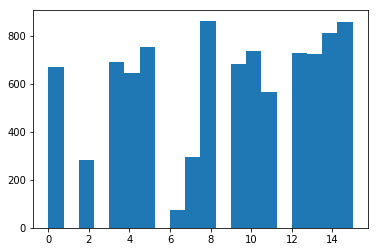

In [23]:
plt.hist(pred_index, bins=20)

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [16]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 85.29333333333334%


In [17]:
rf.score(sk_im_batch_val, label_index)

0.5082666666666666

In [18]:
bands = np.arange(1,23)

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.03177494086457575
Band 2 importance: 0.03734832421234673
Band 3 importance: 0.0451025547399661
Band 4 importance: 0.040840583649110224
Band 5 importance: 0.06662659933577404
Band 6 importance: 0.05894701857996189
Band 7 importance: 0.05625314866900006
Band 8 importance: 0.03666352982307851
Band 9 importance: 0.03353502262947647
Band 10 importance: 0.04768401687151387
Band 11 importance: 0.05273449233987792
Band 12 importance: 0.0441185464989079
Band 13 importance: 0.03656870147508793
Band 14 importance: 0.04217003993554222
Band 15 importance: 0.048586779906255165
Band 16 importance: 0.047349503774867394
Band 17 importance: 0.04705302963561407
Band 18 importance: 0.04943582368859601
Band 19 importance: 0.04644182913325875
Band 20 importance: 0.04808554757207823
Band 21 importance: 0.038664478492928554
Band 22 importance: 0.044015488172182184


In [19]:
pred_index = rf.predict(sk_im_batch_val)
label_index = np.argmax(sk_label_batch_val, axis=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

NameError: name 'plot_confusion_matrix' is not defined

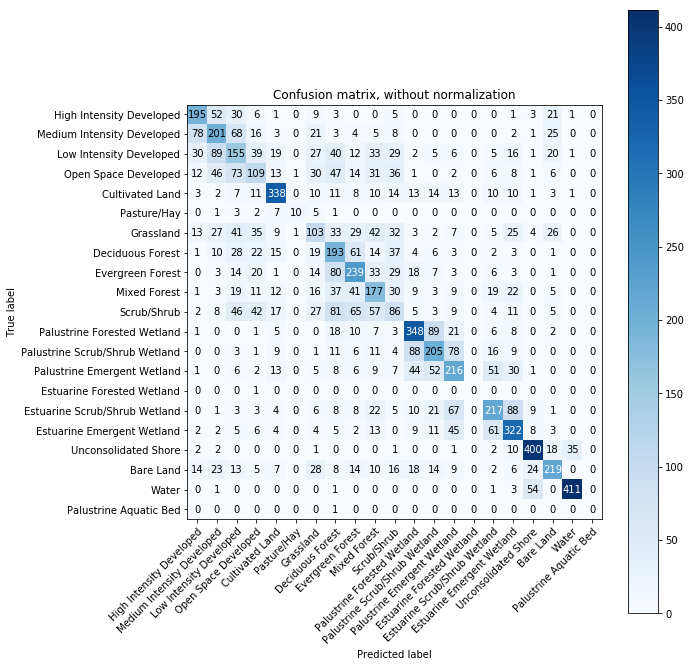

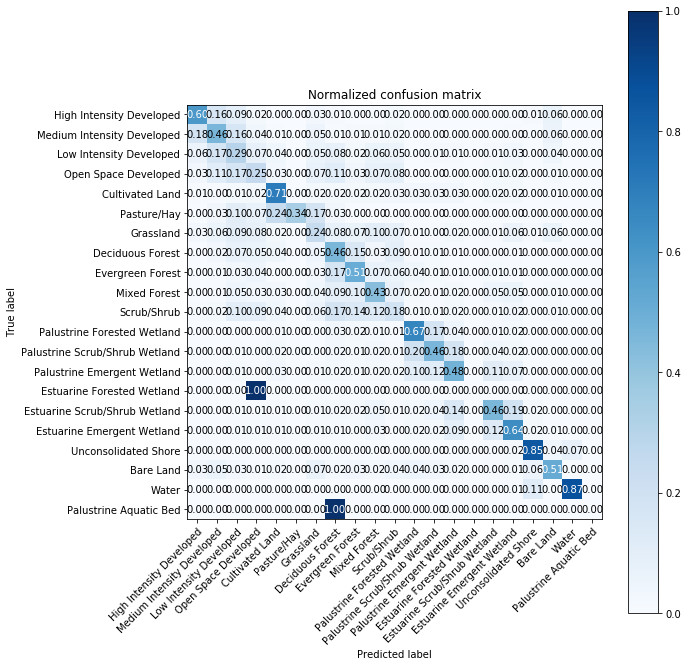

In [19]:
pred_index = rf.predict(sk_im_batch_val)
label_index = np.argmax(sk_label_batch_val, axis=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

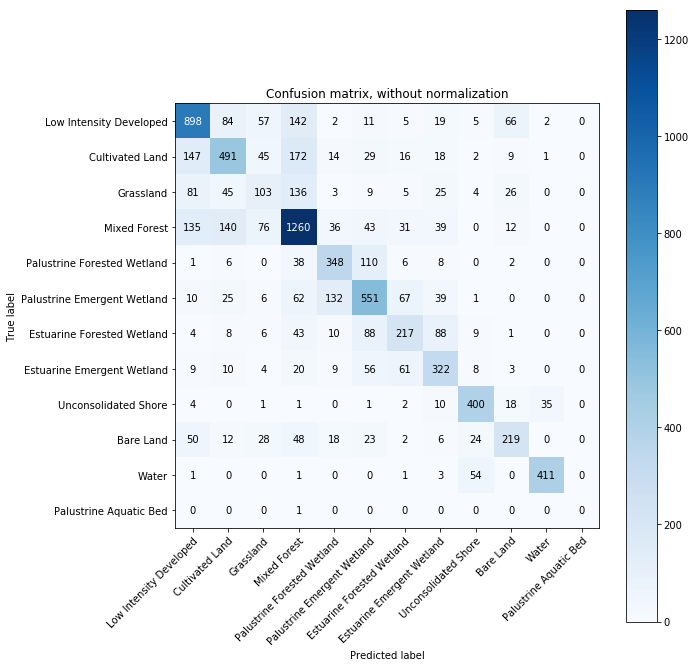

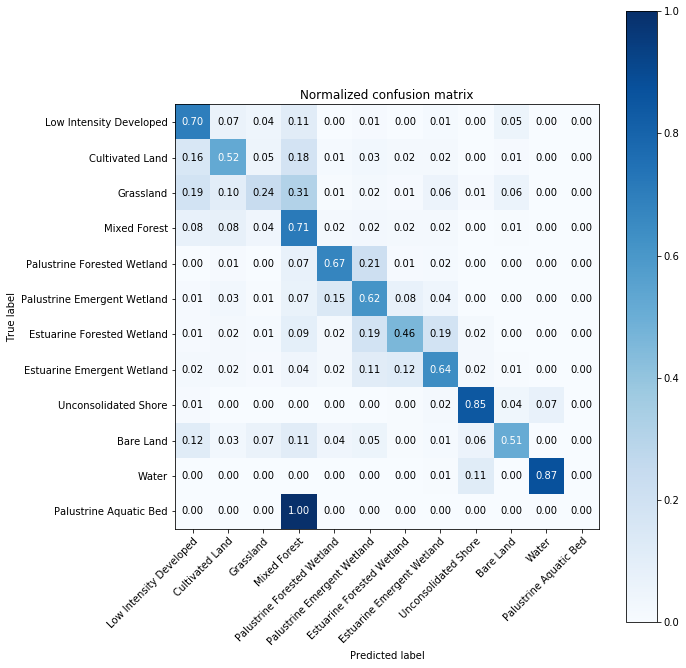

In [21]:
pred_index = merge_classes_extra(pred_index)
label_index = merge_classes_extra(label_index)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

(array([1340.,    0.,  821.,    0.,  326.,    0.,    0.,    0., 1924.,
           0.,  572.,    0.,  921.,    0.,  413.,    0.,  577.,  507.,
         356.,  449.]),
 array([ 4.  ,  4.85,  5.7 ,  6.55,  7.4 ,  8.25,  9.1 ,  9.95, 10.8 ,
        11.65, 12.5 , 13.35, 14.2 , 15.05, 15.9 , 16.75, 17.6 , 18.45,
        19.3 , 20.15, 21.  ]),
 <a list of 20 Patch objects>)

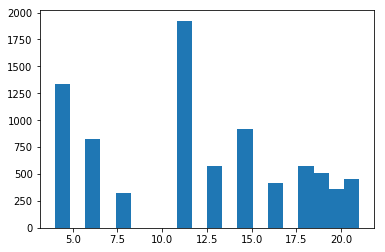

In [22]:
plt.hist(pred_index, bins=20)

#### Creating training data that contains a 3x3 tile

In [23]:
batch_size = len(train_px)
sk_im_batch, sk_label_batch = sk_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, 7, 7, train_px, batch_size, merge=False)
print(sk_im_batch.shape, sk_label_batch.shape)

(32823, 490) (32823, 26)


In [24]:
batch_size = len(val_px)
sk_im_batch_val, sk_label_batch_val = sk_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, 7, 7, val_px, batch_size, merge=False)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(8206, 490) (8206, 26)


In [25]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [26]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 100.0%


In [27]:
label_index = np.argmax(sk_label_batch_val, axis=1)

rf.score(sk_im_batch_val, label_index)

0.6118693638800877

In [28]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.0014906754902459785
Band 2 importance: 0.0014123066939219601
Band 3 importance: 0.0014312665779239327
Band 4 importance: 0.001319761453361226
Band 5 importance: 0.0016542782767735554
Band 6 importance: 0.0013676053988538606
Band 7 importance: 0.0013424522706975681
Band 8 importance: 0.001965979019403379
Band 9 importance: 0.0020285101201014334
Band 10 importance: 0.0018644414695928911


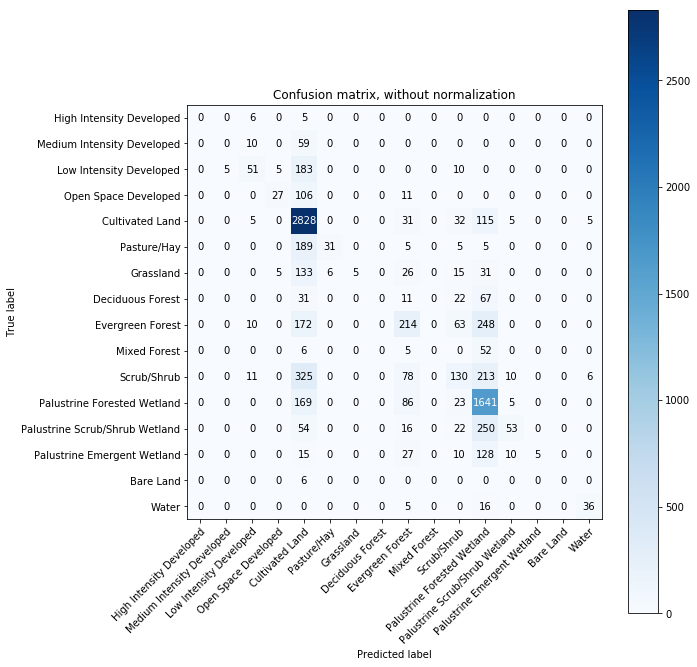

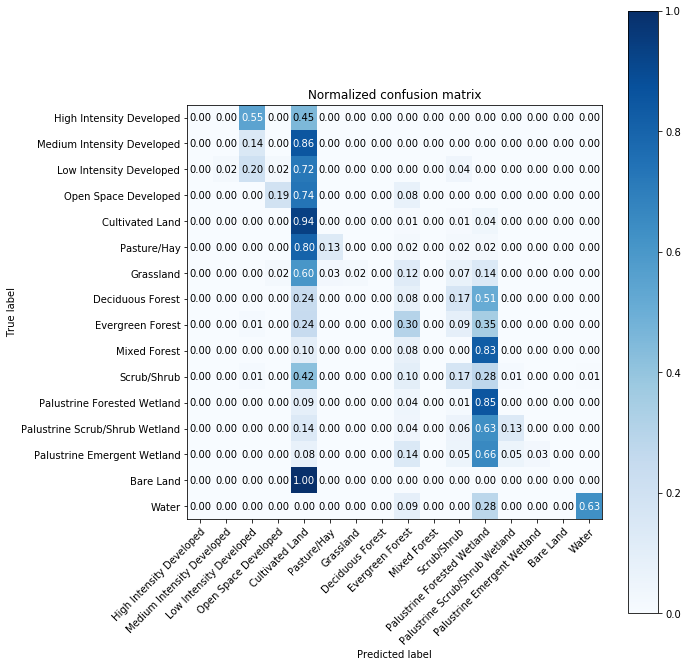

In [29]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

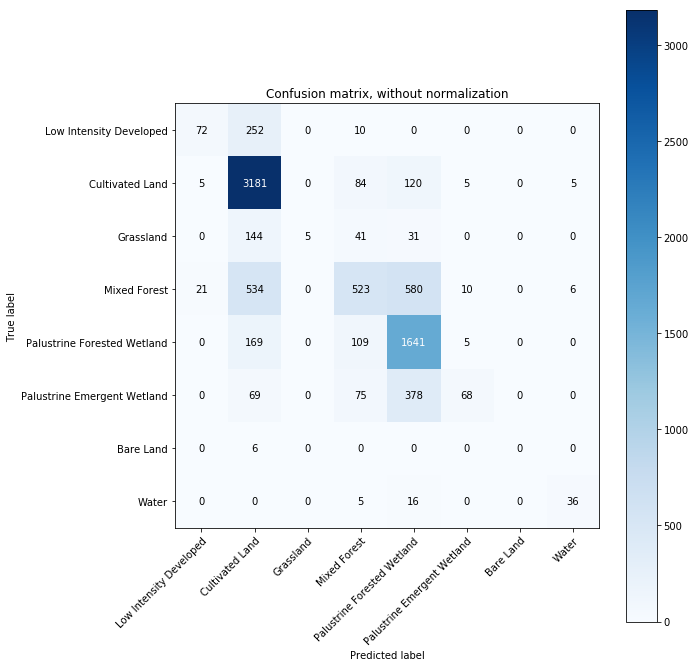

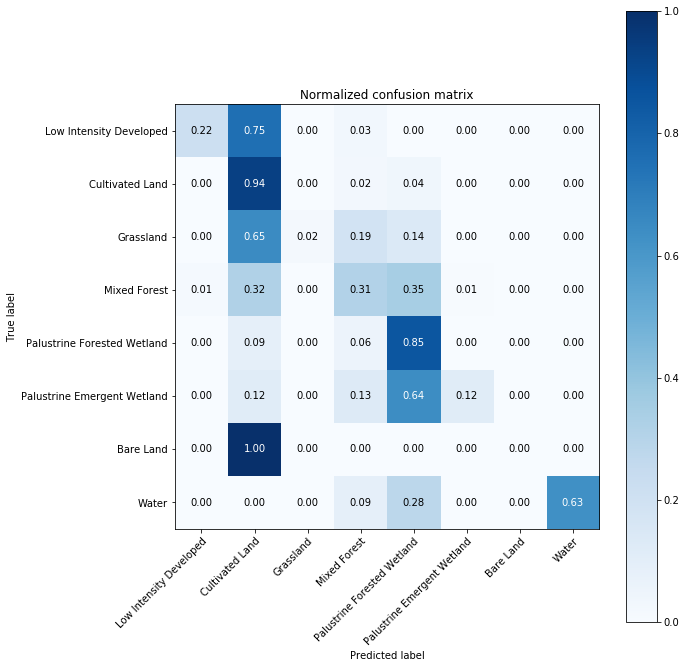

In [30]:
pred_index = merge_classes_extra(pred_index)
label_index = merge_classes_extra(label_index)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

### SVM

In [40]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
svm_clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.3393730227207363

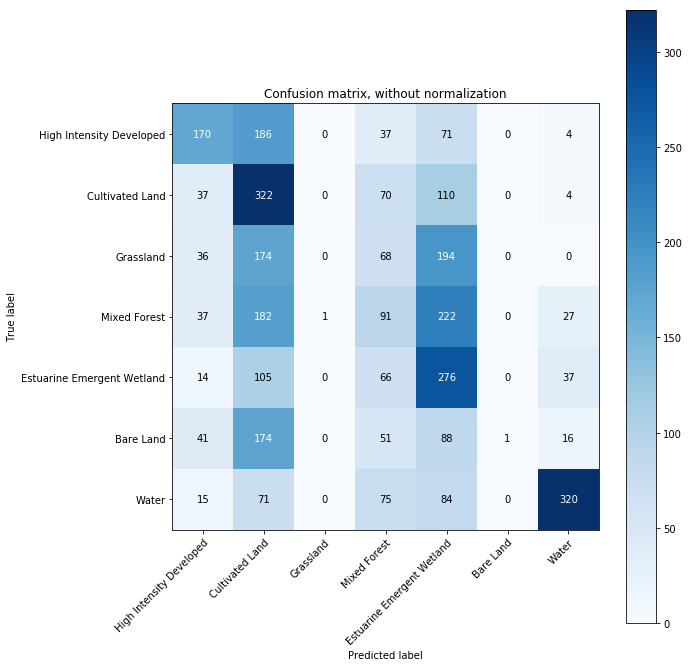

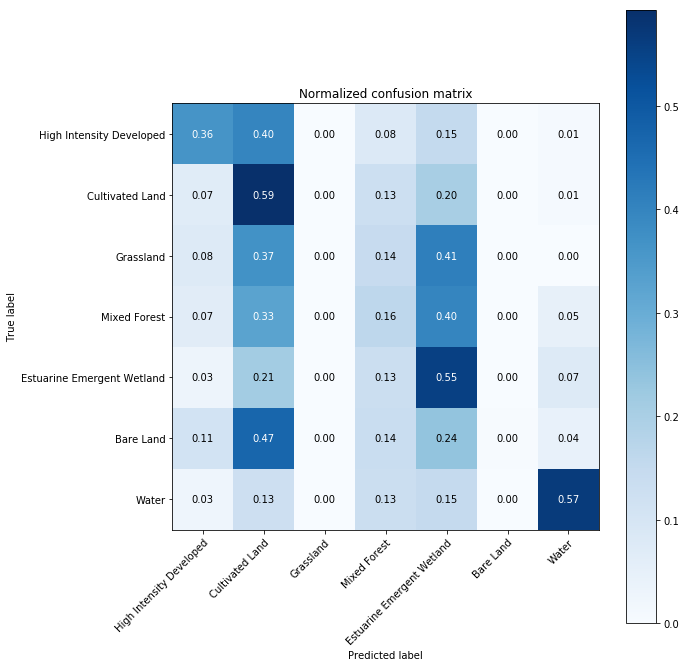

In [42]:
pred_index = svm_clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)